In [1]:
#Import libraries
#For Data handling and manipulation
import pandas as pd
import numpy as np

#For data visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

#For statistical analysis
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

#For data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

#For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#For working with Excel files
import openpyxl

#Suppress system warnings
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the HIV Dataset
hiv_df = pd.read_csv("HIV data 2000-2023.csv", encoding="ISO-8859-1")
#Overview of the datafile
print(hiv_df.shape)
print(hiv_df.columns)
hiv_df.head()

(1552, 11)
Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'Value'],
      dtype='object')


,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,Value
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2023,320 000 [280 000 - 380 000]
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2022,320 000 [280 000 - 380 000]
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2021,320 000 [280 000 - 380 000]
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2020,320 000 [280 000 - 370 000]
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2015,300 000 [260 000 - 350 000]


In [3]:
#Check for missing values
hiv_df.isnull().sum()

IndicatorCode          0
Indicator              0
ValueType              0
ParentLocationCode     0
ParentLocation         0
Location type          0
SpatialDimValueCode    0
Location               0
Period type            0
Period                 0
Value                  0
dtype: int64

In [4]:
#Check for data types and sample values
hiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   IndicatorCode        1552 non-null   object
 1   Indicator            1552 non-null   object
 2   ValueType            1552 non-null   object
 3   ParentLocationCode   1552 non-null   object
 4   ParentLocation       1552 non-null   object
 5   Location type        1552 non-null   object
 6   SpatialDimValueCode  1552 non-null   object
 7   Location             1552 non-null   object
 8   Period type          1552 non-null   object
 9   Period               1552 non-null   int64 
 10  Value                1552 non-null   object
dtypes: int64(1), object(10)
memory usage: 133.5+ KB


In [5]:
#Rename columns for clarity
hiv_df.rename(columns = {
    "Location": "Country",
    "Period": "Year",
    "Value": "hiv_cases",
    "ParentLocationCode": "who_region",
    "ParentLocation": "who_region_name"
}, inplace=True)
hiv_df.head()

,IndicatorCode,Indicator,ValueType,who_region,who_region_name,Location type,SpatialDimValueCode,Country,Period type,Year,hiv_cases
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2023,320 000 [280 000 - 380 000]
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2022,320 000 [280 000 - 380 000]
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2021,320 000 [280 000 - 380 000]
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2020,320 000 [280 000 - 370 000]
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2015,300 000 [260 000 - 350 000]


In [6]:
#Remove the range of numbers in hiv_cases and remain with the first number
import re
#Define a function to extract the first numeric part
def extract_estimate(value):
    if isinstance(value, str):
        match = re.search(r"(\d[\d\s]*)", value)
        if match:
            cleaned = match.group(1).replace(" ", "")
            if cleaned.isdigit():
                return int(cleaned)
        return np.nan
    elif isinstance(value, (int, float)):
        return value
    return np.nan

In [7]:
#Apply the function
hiv_df["hiv_cases"] = hiv_df["hiv_cases"].apply(extract_estimate)
print(hiv_df["hiv_cases"].head(10))
print(hiv_df["hiv_cases"].dtype)

0    320000.0
1    320000.0
2    320000.0
3    320000.0
4    300000.0
5    250000.0
6    190000.0
7    140000.0
8     81000.0
9     82000.0
Name: hiv_cases, dtype: float64
float64


In [8]:
#Total cases per country over all years (Top 75%)
total_by_country = hiv_df.groupby("Country")["hiv_cases"].sum().sort_values(ascending=False).reset_index()
total_by_country.head()

,Country,hiv_cases
0,South Africa,51400000.0
1,Mozambique,15150000.0
2,Nigeria,15000000.0
3,Kenya,12000000.0
4,United Republic of Tanzania,11600000.0


In [9]:
#Calculate the cumulative %
total_sum = total_by_country["hiv_cases"].sum()
total_by_country["Cumulative Percent"] = 100 * total_by_country["hiv_cases"].cumsum()/total_sum
total_by_country["Cumulative Percent"].head()

0    22.613912
1    29.279297
2    35.878688
3    41.158200
4    46.261729
Name: Cumulative Percent, dtype: float64

In [10]:
#Get the top 75% countries
top_75_countries = total_by_country[total_by_country["Cumulative Percent"]<=75]["Country"].to_list()
top_75_countries

['South Africa',
 'Mozambique',
 'Nigeria',
 'Kenya',
 'United Republic of Tanzania',
 'Zimbabwe',
 'Uganda',
 'Zambia',
 'Malawi',
 'Brazil',
 'Thailand',
 'Ethiopia',
 'Democratic Republic of the Congo',
 "Cote d'Ivoire"]

In [11]:
print(len(top_75_countries))
print(top_75_countries)

14
['South Africa', 'Mozambique', 'Nigeria', 'Kenya', 'United Republic of Tanzania', 'Zimbabwe', 'Uganda', 'Zambia', 'Malawi', 'Brazil', 'Thailand', 'Ethiopia', 'Democratic Republic of the Congo', "Cote d'Ivoire"]


In [12]:
#Visualization of the top 75% HIV contributors
top_hiv_df = hiv_df[hiv_df["Country"].isin(top_75_countries)]
top_hiv_df

,IndicatorCode,Indicator,ValueType,who_region,who_region_name,Location type,SpatialDimValueCode,Country,Period type,Year,hiv_cases
48,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2023,420000.0
49,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2022,430000.0
50,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2021,430000.0
51,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2020,440000.0
52,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2015,460000.0
...,...,...,...,...,...,...,...,...,...,...,...
1323,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,SEAR,South-East Asia,Country,THA,Thailand,Year,2020,590000.0
1324,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,SEAR,South-East Asia,Country,THA,Thailand,Year,2015,640000.0
1325,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,SEAR,South-East Asia,Country,THA,Thailand,Year,2010,720000.0
1326,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,SEAR,South-East Asia,Country,THA,Thailand,Year,2005,810000.0


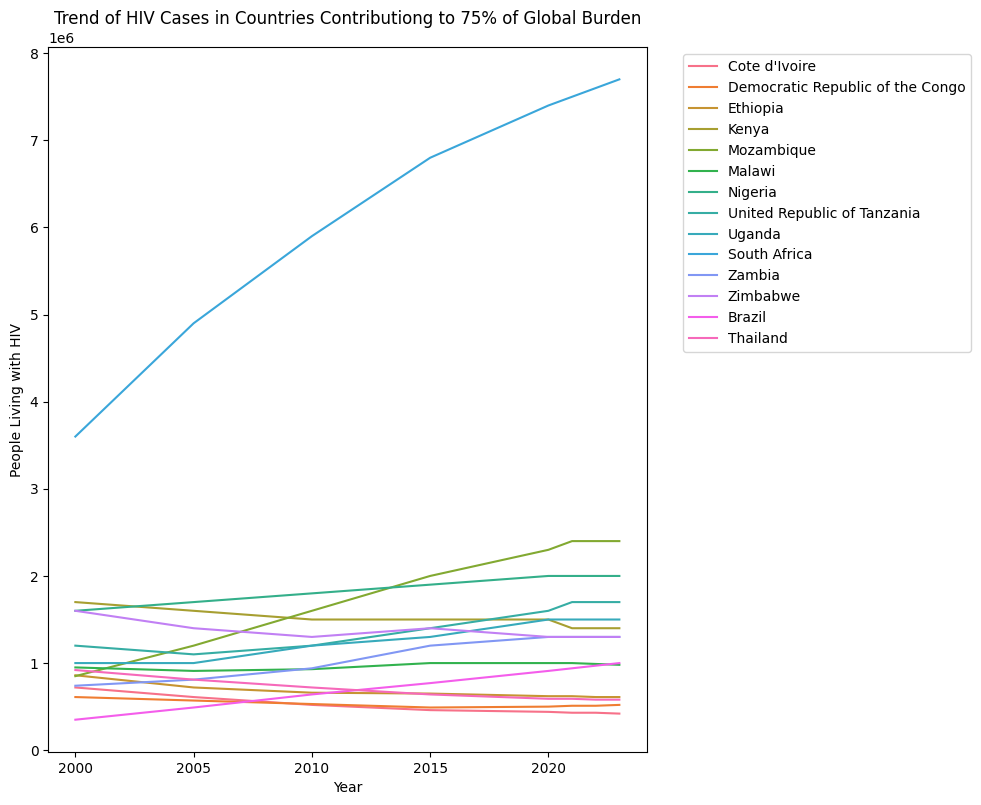

In [13]:
#Visualization of the top 75% HIV contributors
top_hiv_df = hiv_df[hiv_df["Country"].isin(top_75_countries)]
#Plot trends
plt.figure(figsize=(10,8))
sns.lineplot(data=top_hiv_df, x="Year", y="hiv_cases", hue="Country", estimator="sum", ci=None)
plt.title("Trend of HIV Cases in Countries Contributiong to 75% of Global Burden")
plt.xlabel("Year")
plt.ylabel("People Living with HIV")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

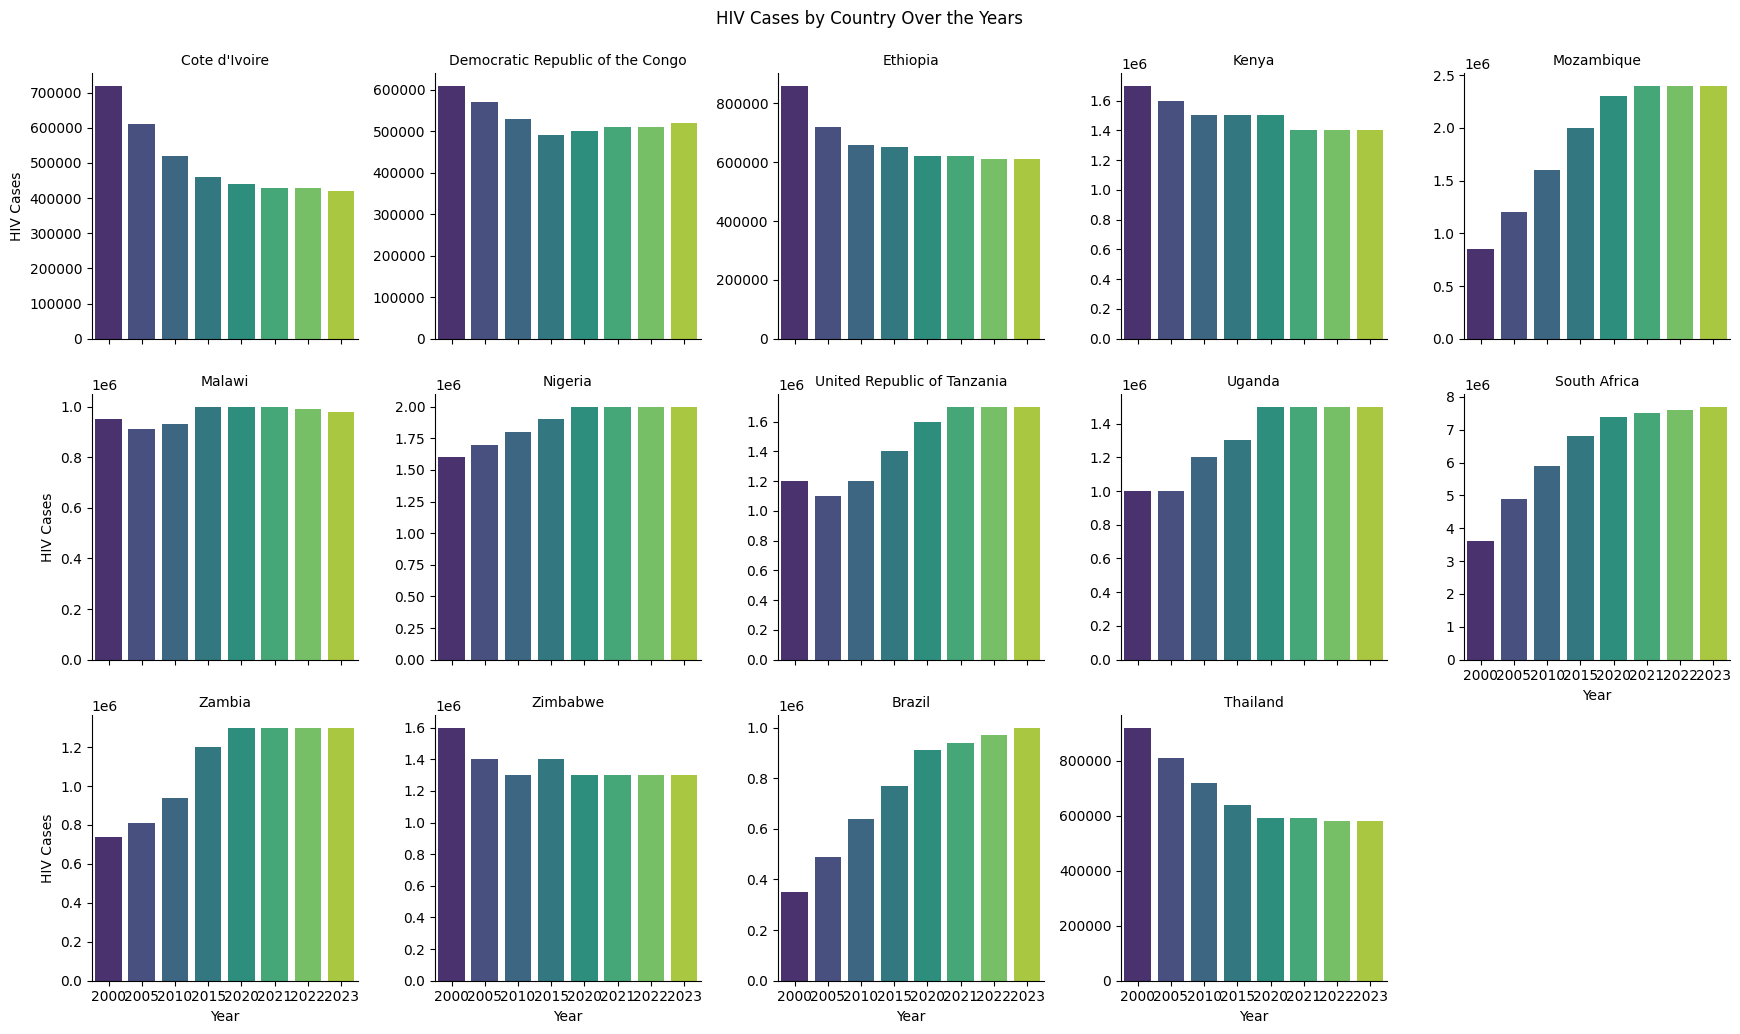

In [14]:
#For better visualization, used facet plot
g = sns.FacetGrid(top_hiv_df, col="Country", col_wrap=5, height=3.5, sharey=False)
g.map_dataframe(sns.barplot, x="Year", y="hiv_cases", palette="viridis")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "HIV Cases")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("HIV Cases by Country Over the Years")
plt.show()

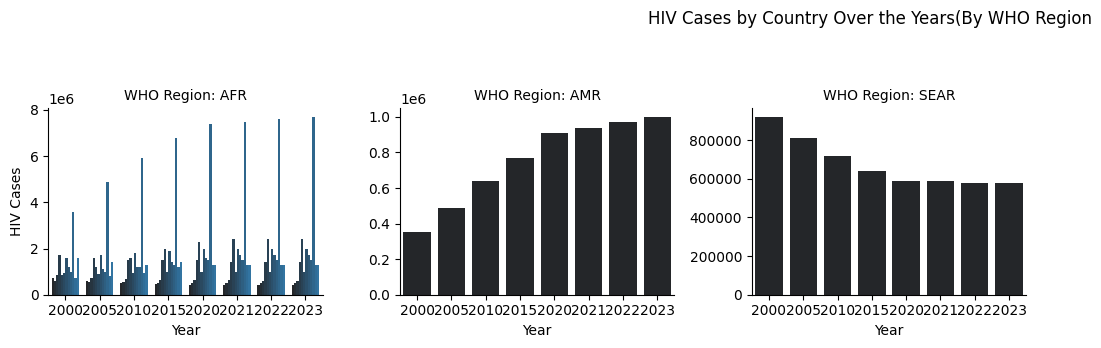

In [15]:
#Visualization of the top 75% HIV contributors
top_hiv_df = hiv_df[hiv_df["Country"].isin(top_75_countries)]
#For better visualization, used facet plot
g = sns.FacetGrid(top_hiv_df, col="who_region", col_wrap=5, height=3.5, sharey=False)
g.map_dataframe(sns.barplot, x="Year", y="hiv_cases", hue="Country", estimator="sum", ci=None)
#Set labels
g.set_titles("WHO Region: {col_name}")
g.set_axis_labels("Year", "HIV Cases")
plt.subplots_adjust(top=0.7)
g.fig.suptitle("HIV Cases by Country Over the Years(By WHO Region")
plt.show()

In [16]:
#Explore the poverty dataset before merging to check for similar columns
poverty_df = pd.read_excel("multidimensional_poverty.xlsx", engine="openpyxl")
#Overview of the datafile
print(poverty_df.info())
poverty_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 16 columns):
 #   Column                                                                                                               Non-Null Count  Dtype 
---  ------                                                                                                               --------------  ----- 
 0   Individuals in households deprived in each indicator, 110 economies, circa year 2021 (2018-2023)
Date: October 2024  111 non-null    object
 1   Unnamed: 1                                                                                                           111 non-null    object
 2   Unnamed: 2                                                                                                           111 non-null    object
 3   Unnamed: 3                                                                                                           111 non-null    object
 4   Unnamed: 4          

,"Individuals in households deprived in each indicator, 110 economies, circa year 2021 (2018-2023)\nDate: October 2024",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),NaN,NaN,NaN,NaN,NaN,Multidimensional poverty headcount ratio (%)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),NaN
2,SSA,AGO,Angola,2018,IDREA,2018,N,c,2,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
3,ECA,ALB,Albania,2012,HBS,2018,N,c,1,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
4,LAC,ARG,Argentina,2010,EPHC-S2,2021,U,i,3,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573
5,ECA,ARM,Armenia,2010,ILCS,2021,N,c,1,0.523521,0,1.793004,0,0.397725,0.660082,0.523521
6,EAP,AUS,Australia,2010,SIH-LIS,2018,N,I,3,0.51688,1.71188,-,0,0,-,2.21577
7,ECA,AUT,Austria,2009,EU-SILC,2022,N,i,2,0.485822,0.176422,-,0,-,0,0.662245
8,SSA,BDI,Burundi,2013,EICVMB,2020,N,c,1,62.065762,44.881231,34.211618,90.568537,91.007495,12.021417,79.209852
9,ECA,BEL,Belgium,2009,EU-SILC,2022,N,i,2,0.029965,0.64869,-,0,-,0,0.679716


In [17]:
#Data preprocessing and cleaning before merging
#Reset the header at row 2
clean_poverty_df = poverty_df.iloc[2:].reset_index(drop=True)
clean_poverty_df

,"Individuals in households deprived in each indicator, 110 economies, circa year 2021 (2018-2023)\nDate: October 2024",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,SSA,AGO,Angola,2018,IDREA,2018,N,c,2,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
1,ECA,ALB,Albania,2012,HBS,2018,N,c,1,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
2,LAC,ARG,Argentina,2010,EPHC-S2,2021,U,i,3,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573
3,ECA,ARM,Armenia,2010,ILCS,2021,N,c,1,0.523521,0,1.793004,0,0.397725,0.660082,0.523521
4,EAP,AUS,Australia,2010,SIH-LIS,2018,N,I,3,0.51688,1.71188,-,0,0,-,2.21577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,ECA,UZB,Uzbekistan,2022,HBS,2022,N,c,1,2.253092,0,-,0.12747,21.786885,10.693686,2.253092
106,EAP,VNM,Viet Nam,2010,VHLSS,2022,N,c,2,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184
107,EAP,VUT,Vanuatu,2010,NSDP,2019,N,c,0,9.963333,25.723079,13.404277,26.994166,42.970088,11.813611,19.892171
108,SSA,ZMB,Zambia,2010,LCMS-VIII,2022,N,c,4,64.341974,16.267821,23.39835,45.135146,53.505135,26.849246,66.506058


In [18]:
#Rename the columns
new_column_names = [
    "Region", "CountryCode", "Country", "Year", "SurveyName", "SurveyYear", "SurveyCoverage", "WelfareType", "SurveyComparability",
    "Monetary(%)", "EducationalAttainment(%)", "EducationalEnrollment(%)", "Electricity(%)", "Sanitation(%)", "DrinkingWater(%)", 
    "MultidimensionalPovertyHeadcountRatio(%)",
]
clean_poverty_df.columns = new_column_names

#Remove rows with null country names
clean_poverty_df = clean_poverty_df[clean_poverty_df["Country"].notna()]

#Convert numeric columns
col_numeric = new_column_names[9:]
clean_poverty_df[col_numeric] = clean_poverty_df[col_numeric].apply(pd.to_numeric, errors="coerce")

#Convert year to integer
clean_poverty_df["Year"] = clean_poverty_df["Year"].astype(int)

clean_poverty_df.head()

,Region,CountryCode,Country,Year,SurveyName,SurveyYear,SurveyCoverage,WelfareType,SurveyComparability,Monetary(%),EducationalAttainment(%),EducationalEnrollment(%),Electricity(%),Sanitation(%),DrinkingWater(%),MultidimensionalPovertyHeadcountRatio(%)
0,SSA,AGO,Angola,2018,IDREA,2018,N,c,2,31.122005,29.753423,27.443060,52.639532,53.637516,32.106507,47.203606
1,ECA,ALB,Albania,2012,HBS,2018,N,c,1,0.048107,0.192380,NaN,0.060250,6.579772,9.594966,0.293161
2,LAC,ARG,Argentina,2010,EPHC-S2,2021,U,i,3,0.894218,1.085320,0.731351,0.000000,0.257453,0.364048,0.906573
3,ECA,ARM,Armenia,2010,ILCS,2021,N,c,1,0.523521,0.000000,1.793004,0.000000,0.397725,0.660082,0.523521
4,EAP,AUS,Australia,2010,SIH-LIS,2018,N,I,3,0.516880,1.711880,NaN,0.000000,0.000000,NaN,2.215770


In [19]:
#Check for null values
clean_poverty_df.isnull().sum()

Region                                       0
CountryCode                                  0
Country                                      0
Year                                         0
SurveyName                                   0
SurveyYear                                   0
SurveyCoverage                               0
WelfareType                                  0
SurveyComparability                          0
Monetary(%)                                  0
EducationalAttainment(%)                     1
EducationalEnrollment(%)                    36
Electricity(%)                               1
Sanitation(%)                               25
DrinkingWater(%)                             9
MultidimensionalPovertyHeadcountRatio(%)     0
dtype: int64

In [20]:
#Merge the dataframes now 
merged_df = pd.merge(hiv_df, clean_poverty_df, on=["Country", "Year"], how="inner")
merged_df.head(15)

,IndicatorCode,Indicator,ValueType,who_region,who_region_name,Location type,SpatialDimValueCode,Country,Period type,Year,...,SurveyCoverage,WelfareType,SurveyComparability,Monetary(%),EducationalAttainment(%),EducationalEnrollment(%),Electricity(%),Sanitation(%),DrinkingWater(%),MultidimensionalPovertyHeadcountRatio(%)
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,BEN,Benin,Year,2015,...,N,c,1,12.723279,49.023893,31.661823,34.818304,76.649594,24.109130,45.443240
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2015,...,N,c,2,9.733193,44.493997,24.717054,9.264950,59.909374,17.286547,29.177094
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,GNB,Guinea-Bissau,Year,2010,...,N,c,3,25.962856,20.071073,31.059781,27.570510,60.362864,20.897064,38.730049
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,KEN,Kenya,Year,2015,...,N,c,3,36.146057,10.055726,1.179968,24.500306,22.312516,36.060327,38.490102
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,MWI,Malawi,Year,2010,...,N,c,1,70.060599,54.329389,3.686354,88.757396,75.137657,11.400399,78.252000
5,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,ZMB,Zambia,Year,2010,...,N,c,4,64.341974,16.267821,23.398350,45.135146,53.505135,26.849246,66.506058
6,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AMR,Americas,Country,ARG,Argentina,Year,2010,...,U,i,3,0.894218,1.085320,0.731351,0.000000,0.257453,0.364048,0.906573
7,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AMR,Americas,Country,COL,Colombia,Year,2010,...,N,i,4,7.334666,5.054273,2.794198,1.110965,7.673390,1.721011,7.698172
8,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AMR,Americas,Country,CRI,Costa Rica,Year,2010,...,N,i,3,1.242194,3.650702,0.452292,0.261438,1.557860,0.252125,1.320344
9,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AMR,Americas,Country,DOM,Dominican Republic,Year,2010,...,N,i,5,0.853729,12.177467,5.423051,0.474999,5.528953,4.678269,1.813273


In [21]:
#Check for the null values after cleaning
merged_df.isnull().sum()

IndicatorCode                               0
Indicator                                   0
ValueType                                   0
who_region                                  0
who_region_name                             0
Location type                               0
SpatialDimValueCode                         0
Country                                     0
Period type                                 0
Year                                        0
hiv_cases                                   4
Region                                      0
CountryCode                                 0
SurveyName                                  0
SurveyYear                                  0
SurveyCoverage                              0
WelfareType                                 0
SurveyComparability                         0
Monetary(%)                                 0
EducationalAttainment(%)                    0
EducationalEnrollment(%)                    7
Electricity(%)                    

In [22]:
#Check for column names
merged_df.columns

Index(['IndicatorCode', 'Indicator', 'ValueType', 'who_region',
       'who_region_name', 'Location type', 'SpatialDimValueCode', 'Country',
       'Period type', 'Year', 'hiv_cases', 'Region', 'CountryCode',
       'SurveyName', 'SurveyYear', 'SurveyCoverage', 'WelfareType',
       'SurveyComparability', 'Monetary(%)', 'EducationalAttainment(%)',
       'EducationalEnrollment(%)', 'Electricity(%)', 'Sanitation(%)',
       'DrinkingWater(%)', 'MultidimensionalPovertyHeadcountRatio(%)'],
      dtype='object')

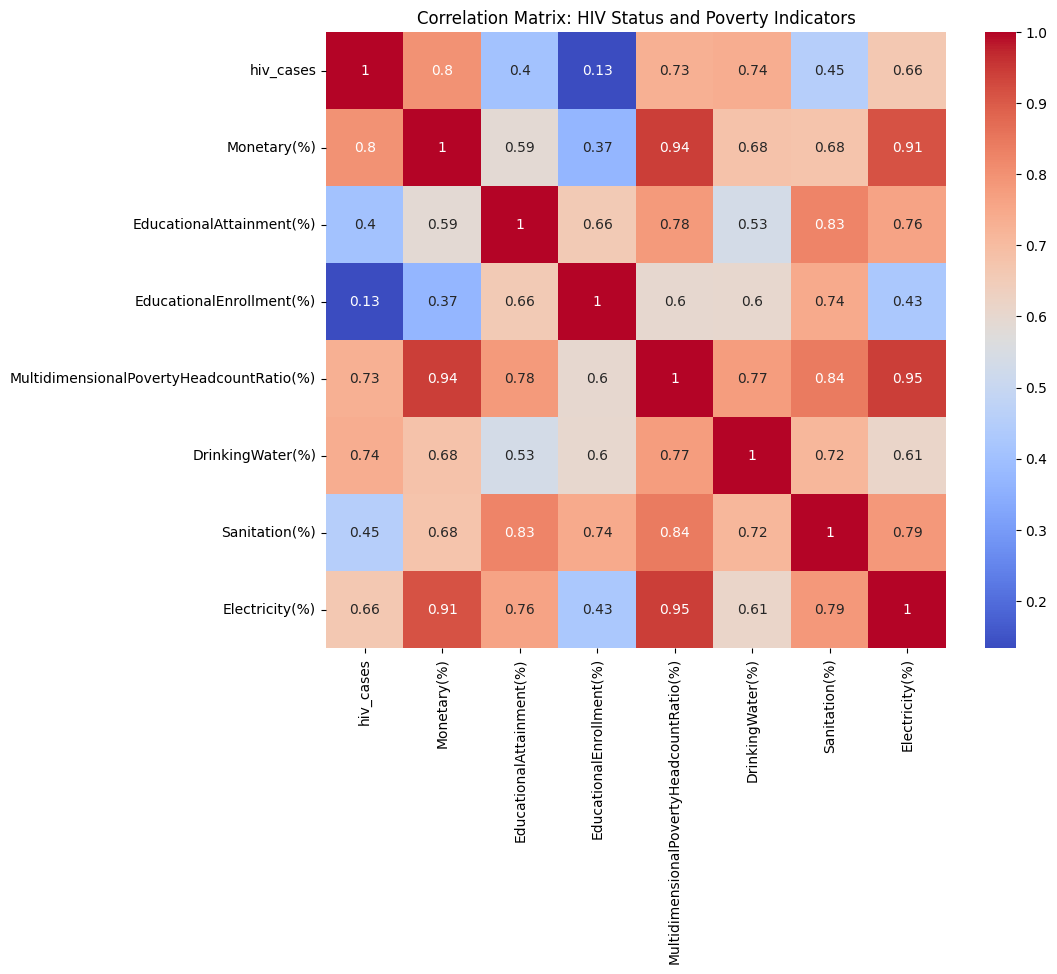

In [23]:
#Build correlation matrix to check the correlation between relevant numerical columns
numerical_cols = [
    'hiv_cases', 'Monetary(%)', 'EducationalAttainment(%)', 'EducationalEnrollment(%)', 'MultidimensionalPovertyHeadcountRatio(%)',
    'DrinkingWater(%)', 'Sanitation(%)', 'Electricity(%)', 
]
#Computation of correlation matrix
correlation_matrix = merged_df[numerical_cols].corr()
#Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix: HIV Status and Poverty Indicators")
plt.show()

In [24]:
#Rename columns with special characters to avoid using patsy Q() and easier correlation analysis
merged_df = merged_df.rename(columns={
    "MultidimensionalPovertyHeadcountRatio(%)": "poverty_ratio",
    "Monetary(%)": "monetary",
    "EducationalAttainment(%)": "educ_attain",
    "EducationalEnrollment(%)": "educ_enroll",
    "Electricity(%)": "electricity",
    "Sanitation(%)": "sanitation",
    "DrinkingWater(%)": "drinking_water"
})
merged_df.head()

,IndicatorCode,Indicator,ValueType,who_region,who_region_name,Location type,SpatialDimValueCode,Country,Period type,Year,...,SurveyCoverage,WelfareType,SurveyComparability,monetary,educ_attain,educ_enroll,electricity,sanitation,drinking_water,poverty_ratio
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,BEN,Benin,Year,2015,...,N,c,1,12.723279,49.023893,31.661823,34.818304,76.649594,24.109130,45.443240
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2015,...,N,c,2,9.733193,44.493997,24.717054,9.264950,59.909374,17.286547,29.177094
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,GNB,Guinea-Bissau,Year,2010,...,N,c,3,25.962856,20.071073,31.059781,27.570510,60.362864,20.897064,38.730049
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,KEN,Kenya,Year,2015,...,N,c,3,36.146057,10.055726,1.179968,24.500306,22.312516,36.060327,38.490102
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,MWI,Malawi,Year,2010,...,N,c,1,70.060599,54.329389,3.686354,88.757396,75.137657,11.400399,78.252000


In [25]:
#Drop all the null values
clean_merged_df = merged_df.dropna(subset=[
    "poverty_ratio", "monetary", "educ_attain", "educ_enroll", "electricity", "sanitation", "drinking_water"
])
clean_merged_df = clean_merged_df.reset_index(drop=True)
clean_merged_df.head()

,IndicatorCode,Indicator,ValueType,who_region,who_region_name,Location type,SpatialDimValueCode,Country,Period type,Year,...,SurveyCoverage,WelfareType,SurveyComparability,monetary,educ_attain,educ_enroll,electricity,sanitation,drinking_water,poverty_ratio
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,BEN,Benin,Year,2015,...,N,c,1,12.723279,49.023893,31.661823,34.818304,76.649594,24.109130,45.443240
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,CIV,Cote d'Ivoire,Year,2015,...,N,c,2,9.733193,44.493997,24.717054,9.264950,59.909374,17.286547,29.177094
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,GNB,Guinea-Bissau,Year,2010,...,N,c,3,25.962856,20.071073,31.059781,27.570510,60.362864,20.897064,38.730049
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,KEN,Kenya,Year,2015,...,N,c,3,36.146057,10.055726,1.179968,24.500306,22.312516,36.060327,38.490102
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,MWI,Malawi,Year,2010,...,N,c,1,70.060599,54.329389,3.686354,88.757396,75.137657,11.400399,78.252000


In [26]:
#Check for missing values in Country
print(clean_merged_df["Country"].isnull().sum())

0


In [27]:
clean_merged_df = clean_merged_df.reset_index(drop=True)

In [28]:
print("Unique countries:", clean_merged_df["Country"].nunique())
print("Shape of DataFrame:", clean_merged_df.shape)

Unique countries: 33
Shape of DataFrame: (33, 25)


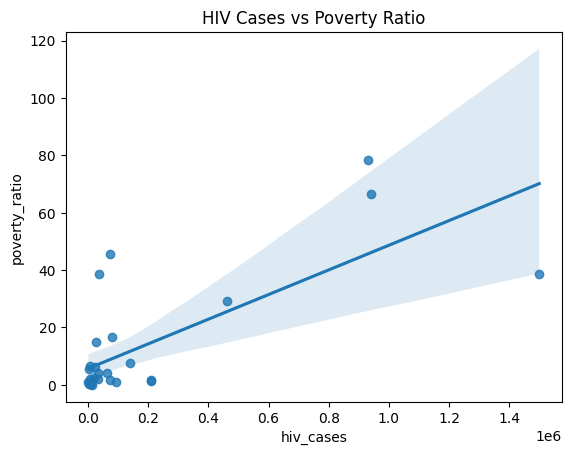

In [29]:
#Relationship between HIV and poverty ratio
sns.regplot(data=clean_merged_df, x="hiv_cases", y="poverty_ratio")
plt.title("HIV Cases vs Poverty Ratio")
plt.show()

In [30]:
#Run a simple regression
simple_model = smf.ols("poverty_ratio ~ hiv_cases", data=clean_merged_df).fit()
print(simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:          poverty_ratio   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     30.20
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           8.07e-06
Time:                        22:13:38   Log-Likelihood:                -117.87
No. Observations:                  29   AIC:                             239.7
Df Residuals:                      27   BIC:                             242.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6937      3.028      1.880      0.0

In [31]:
#Jarque-Bera (JB) and Omnibus are significant suggesting skewness. Trying logging to reduce skewness
clean_merged_df["log_hiv_cases"] = np.log1p(clean_merged_df["hiv_cases"])
logged_model = smf.ols("poverty_ratio ~ hiv_cases", data=clean_merged_df).fit()
print(logged_model.summary())

                            OLS Regression Results                            
Dep. Variable:          poverty_ratio   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     30.20
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           8.07e-06
Time:                        22:13:40   Log-Likelihood:                -117.87
No. Observations:                  29   AIC:                             239.7
Df Residuals:                      27   BIC:                             242.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6937      3.028      1.880      0.0

In [32]:
#Look if HIV is correlated with other socioeconomic factors
model = smf.ols("""
    poverty_ratio ~ hiv_cases + educ_attain + educ_enroll + electricity + sanitation + drinking_water + monetary
""", data=clean_merged_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          poverty_ratio   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     614.7
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           7.93e-23
Time:                        22:13:42   Log-Likelihood:                -51.507
No. Observations:                  29   AIC:                             119.0
Df Residuals:                      21   BIC:                             130.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.4170      0.465     -3.

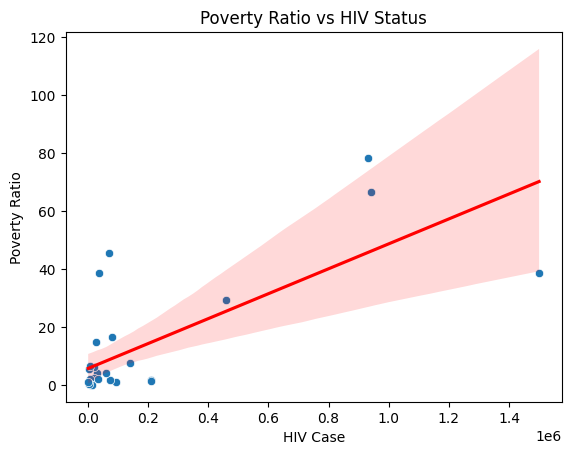

In [33]:
#Plot a correlation matrix
sns.scatterplot(data=clean_merged_df, x="hiv_cases", y="poverty_ratio")
sns.regplot(data=clean_merged_df, x="hiv_cases", y="poverty_ratio", scatter=False, color="red")
plt.title("Poverty Ratio vs HIV Status")
plt.xlabel("HIV Case")
plt.ylabel("Poverty Ratio")
plt.show()

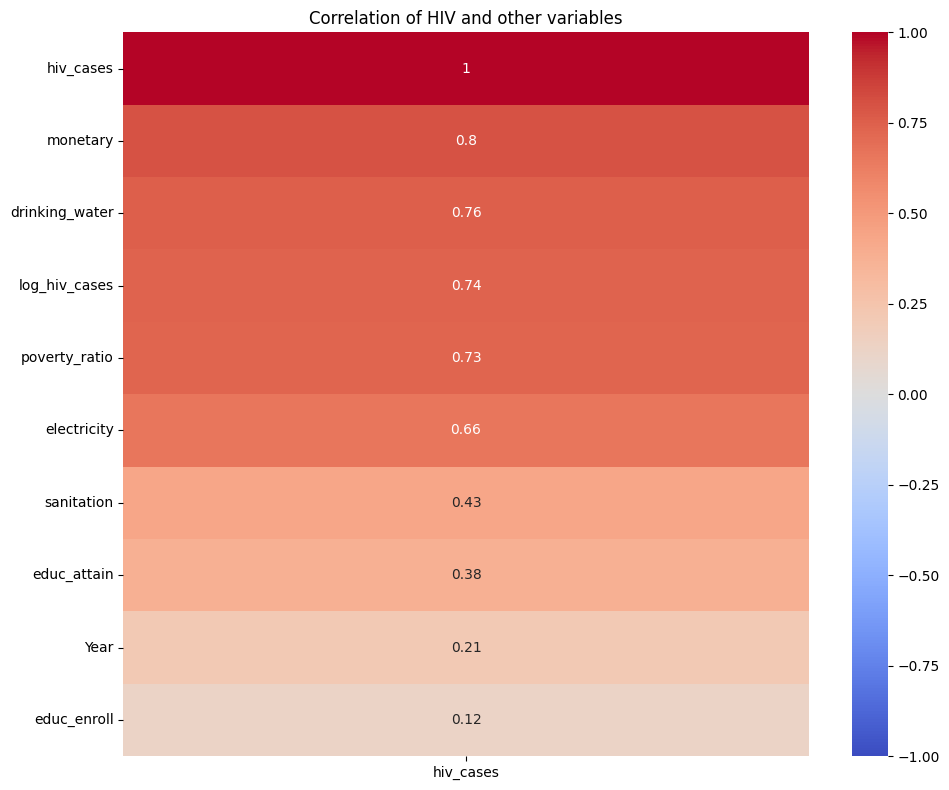

In [34]:
#Plot the correlation of HIV with other variables
plt.figure(figsize=(10,8))
corr_matrix=clean_merged_df.corr(numeric_only=True)
sns.heatmap(corr_matrix[["hiv_cases"]].sort_values(by="hiv_cases", ascending=False),
           annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation of HIV and other variables")
plt.tight_layout()
plt.show()

In [35]:
print(clean_merged_df["Country"].isnull().sum())

0


In [36]:
clean_merged_df = clean_merged_df.dropna(subset=["log_hiv_cases"])

In [37]:
print(clean_merged_df.isnull().sum())

IndicatorCode          0
Indicator              0
ValueType              0
who_region             0
who_region_name        0
Location type          0
SpatialDimValueCode    0
Country                0
Period type            0
Year                   0
hiv_cases              0
Region                 0
CountryCode            0
SurveyName             0
SurveyYear             0
SurveyCoverage         0
WelfareType            0
SurveyComparability    0
monetary               0
educ_attain            0
educ_enroll            0
electricity            0
sanitation             0
drinking_water         0
poverty_ratio          0
log_hiv_cases          0
dtype: int64


In [38]:
#Visualize using the mixed effects model to include random effects like country and year.
formula = "hiv_cases ~ poverty_ratio + monetary + educ_attain + educ_enroll + electricity + sanitation + drinking_water"
#Fit model with random effects of country and year
model = mixedlm(formula, clean_merged_df, groups=clean_merged_df["Country"])
result = model.fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     hiv_cases      
No. Observations:      29          Method:                 REML           
No. Groups:            29          Scale:                  8725542664.4250
Min. group size:       1           Log-Likelihood:         -304.1227      
Max. group size:       1           Converged:              Yes            
Mean group size:       1.0                                                
--------------------------------------------------------------------------
                   Coef.       Std.Err.   z    P>|z|    [0.025     0.975] 
--------------------------------------------------------------------------
Intercept          -24841.330 38945.922 -0.638 0.524 -101173.935 51491.275
poverty_ratio       -3768.729  9192.998 -0.410 0.682  -21786.673 14249.215
monetary            18730.322  6697.667  2.797 0.005    5603.135 31857.508
educ_attain          9450.998  2224.321  4.2

In [ ]:
"""
Findings from the HIV Case Analysis
Countries with a decline in estimated HIV cases consistently are 
Ethiopia - 870,000 - 610,000
Cote d'Ivoire - 720,000 -  430,000
Kenya - 1.7M - 1.4M
Zimbabwe - 1.6M - 1.3M
Thailand - 900,000 - 580,000
Suggests success in public health interventions or improved outreach and treatment programs.
Countries with increased HIV Cases
Mozambique - 900,000 - 2.4M
South Africa - 3.5M - 7.7M (highest)
Nigeria - 1.5M - 2M 
Brazil - 300,000 - 1M
Zambia and Tanzania - Grew consistently recently
Uganda and Malawi - Increased but plateaued 2015-2020
Increase could reflect better testing, population growth or increased transmission rates.
DRC, Malawi and Zambia have mixed trends initially declining and rose again recently, suggesting either population growth, ineffective public health outreach models.
Regional Trends by WHO Region
African Region
Overall rise in HIV trends with sharp increases around South Africa and Mozambique.
There is an increase in some countries and others decrease showing variation
American Region
HIV cases consistently increased especially in regions like Brazil
Compared to Africa, it showed a steady but slower rise.
South East Asia
Marked decline in HIV cases especially in areas like Thailand and other SEA countries.
Overall -  Progress is uneven as countries like Ethiopia, Zimbabwe, Thailand have made strong progress while others like South Africa and Mozambique still face overwhelming cases.
Plateauing trends and mixed trends in some countries like Zambia and Malawi suggest treatment scaling has stabilized the epidemic but not effective enough.
South Africa needs heavy international and national efforts to help it with its burden, as its cases alone skews the Africa region heavily.

Regression Analyses
There are several correlations between socioeconomic indicators and poverty or emergence of HIV cases. In the OLS model predicting poverty_ratio, model with significant predictors (99.5% of the variance) including monetary support, school enrollment, educational attainment, electricity access and drinking water access are all associated with poverty ratio. HIV cases do not significantly affect or predict poverty in this model.
In the mixed linear model, where HIV is the dependent variable, monetary support, educational attainment and drinking water access are positively associated with HIV cases, and school enrollment shows a negative association. This suggests that while factors like education and infrastructure correlate strongly with poverty ratio, they also relate to HIV cases. Areas with developed education and infrastructure have a higher HIV cases, possibly due to better reporting tools or better funding.
"""

In [39]:
#Load the world wide mortality rate datafile
world_df = pd.read_csv("dataset_datascience.csv")
print(world_df.shape)
print(world_df.info())
world_df.head()

(129564, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129564 entries, 0 to 129563
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   REF_AREA                129564 non-null  object 
 1   Geographic area         129564 non-null  object 
 2   Regional group          7138 non-null    object 
 3   Indicator               129564 non-null  object 
 4   Sex                     129564 non-null  object 
 5   Wealth Quintile         129564 non-null  object 
 6   Series Name             129564 non-null  object 
 7   Series Year             129564 non-null  object 
 8   Reference Date          129564 non-null  float64
 9   Observation Value       129528 non-null  float64
 10  Lower Bound             73949 non-null   float64
 11  Upper Bound             73949 non-null   float64
 12  Standard Error          30793 non-null   float64
 13  Country notes           4710 non-null    object 
 14  Observa

,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
0,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018,1995.5,47.869030,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
1,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018,2000.5,35.349317,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
2,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018,2005.5,27.699219,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
3,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018,2010.5,21.056003,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
4,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018,2015.5,20.167379,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0


In [40]:
#Filter countries that are from Eastern Africa
eac_countries = [
    "Kenya", "Rwanda", "Burundi", "Somalia", "United Republic of Tanzania", "Uganda", "Democratic Republic of the Congo", "South Sudan"
]
eac_df = world_df[world_df["Geographic area"].isin(eac_countries)]
eac_df.head()

,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
6387,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,1993.5,36.41348,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6388,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,1998.5,41.25996,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6389,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,2003.5,32.83915,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6390,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,2008.5,28.46557,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6391,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,2013.5,23.70623,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0


In [41]:
#Filter out neonatal mortality rate from the eac_df
neonatal_df = eac_df[eac_df["Indicator"] == "Neonatal mortality rate"]
neonatal_df.head()

,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
6387,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,1993.5,36.41348,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6388,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,1998.5,41.25996,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6389,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,2003.5,32.83915,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6390,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,2008.5,28.46557,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0
6391,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),2016-2017,2013.5,23.70623,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5.0


In [42]:
#Filter out under five mortality rate from eac_df
under_five_mort_df =  eac_df[eac_df["Indicator"] == "Under-five mortality rate"]
under_five_mort_df.head()

,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
6462,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1989.1,167.6293,...,NaN,Included in IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6463,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1991.5,159.8546,...,NaN,Included in IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6464,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1993.6,166.9109,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6465,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1995.7,177.1552,...,NaN,Included in IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6466,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1998.2,148.7956,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN


In [43]:
#Check for neonatal information
neonatal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 622 entries, 6387 to 112799
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   REF_AREA                622 non-null    object 
 1   Geographic area         622 non-null    object 
 2   Regional group          0 non-null      object 
 3   Indicator               622 non-null    object 
 4   Sex                     622 non-null    object 
 5   Wealth Quintile         622 non-null    object 
 6   Series Name             622 non-null    object 
 7   Series Year             622 non-null    object 
 8   Reference Date          622 non-null    float64
 9   Observation Value       622 non-null    float64
 10  Lower Bound             425 non-null    float64
 11  Upper Bound             425 non-null    float64
 12  Standard Error          195 non-null    float64
 13  Country notes           0 non-null      object 
 14  Observation Status      622 non-null    o

In [44]:
#Keep the useful columns to be used
neonatal_df = neonatal_df[[
    "Geographic area", "Reference Date", "Observation Value", "REF_AREA"
]]
neonatal_df.head()

,Geographic area,Reference Date,Observation Value,REF_AREA
6387,Burundi,1993.5,36.41348,BDI
6388,Burundi,1998.5,41.25996,BDI
6389,Burundi,2003.5,32.83915,BDI
6390,Burundi,2008.5,28.46557,BDI
6391,Burundi,2013.5,23.70623,BDI


In [45]:
print(neonatal_df['Reference Date'].unique())

[1993.5 1998.5 2003.5 2008.5 2013.5 1987.5 1992.5 1997.5 2002.5 2007.5
 1964.5 1969.5 1974.5 1979.5 1984.5 1965.5 1966.5 1967.5 1968.5 1970.5
 1971.5 1972.5 1973.5 1975.5 1976.5 1977.5 1978.5 1980.5 1981.5 1982.5
 1983.5 1985.5 1986.5 1988.5 1989.5 1990.5 1991.5 1994.5 1995.5 1996.5
 1999.5 2000.5 2001.5 2004.5 2005.5 2006.5 2009.5 2010.5 2011.5 2012.5
 2014.5 2015.5 2016.5 2017.5 2018.5 2019.5 2020.5 2021.5 2022.5 2023.5
 1954.5 1959.5 1955.5 1956.5 1957.5 1958.5 1960.5 1961.5 1962.5 1963.5
 2014.9 2006.3]


In [46]:
print(neonatal_df['Geographic area'].unique())

['Burundi' 'Democratic Republic of the Congo' 'Kenya' 'Rwanda' 'Somalia'
 'South Sudan' 'United Republic of Tanzania' 'Uganda']


In [47]:
#Rename columns of neonatal mortality rate for clarity
neonatal_df.columns = [
    "Country", "Year", "Neonatal_Mortality_Rate", "Ref_Area"
]
neonatal_df.head()

,Country,Year,Neonatal_Mortality_Rate,Ref_Area
6387,Burundi,1993.5,36.41348,BDI
6388,Burundi,1998.5,41.25996,BDI
6389,Burundi,2003.5,32.83915,BDI
6390,Burundi,2008.5,28.46557,BDI
6391,Burundi,2013.5,23.70623,BDI


In [48]:
#Check if there are different years.
print(neonatal_df["Year"].unique())

[1993.5 1998.5 2003.5 2008.5 2013.5 1987.5 1992.5 1997.5 2002.5 2007.5
 1964.5 1969.5 1974.5 1979.5 1984.5 1965.5 1966.5 1967.5 1968.5 1970.5
 1971.5 1972.5 1973.5 1975.5 1976.5 1977.5 1978.5 1980.5 1981.5 1982.5
 1983.5 1985.5 1986.5 1988.5 1989.5 1990.5 1991.5 1994.5 1995.5 1996.5
 1999.5 2000.5 2001.5 2004.5 2005.5 2006.5 2009.5 2010.5 2011.5 2012.5
 2014.5 2015.5 2016.5 2017.5 2018.5 2019.5 2020.5 2021.5 2022.5 2023.5
 1954.5 1959.5 1955.5 1956.5 1957.5 1958.5 1960.5 1961.5 1962.5 1963.5
 2014.9 2006.3]


In [49]:
#Confirm if all the countries are present
print(neonatal_df['Country'].unique())

['Burundi' 'Democratic Republic of the Congo' 'Kenya' 'Rwanda' 'Somalia'
 'South Sudan' 'United Republic of Tanzania' 'Uganda']


In [50]:
#Make sure Tanzania is presented properly
neonatal_df["Country"] = neonatal_df["Country"].replace({
    "United Republic of Tanzania": "Tanzania"
})

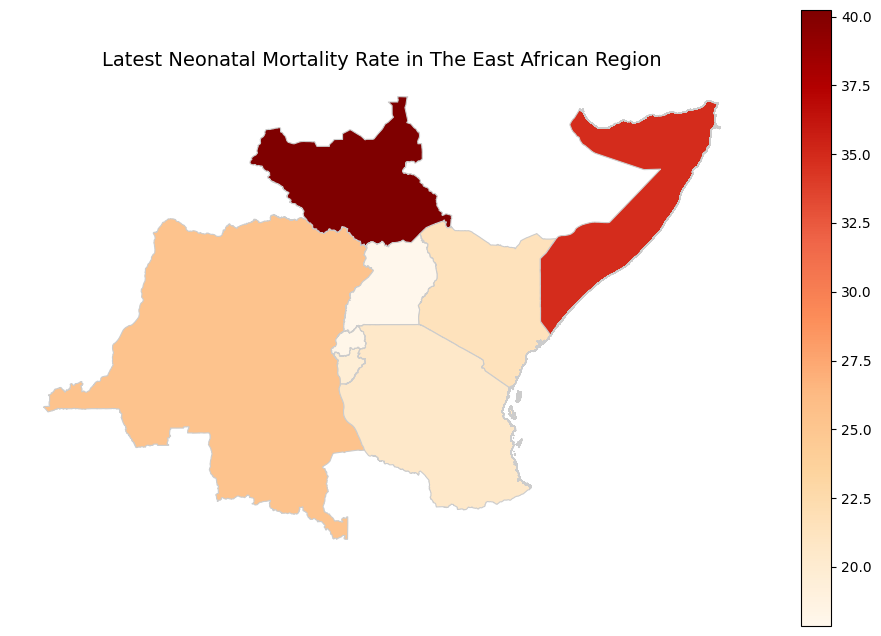

In [51]:
#List of shapefile paths to the country's shapefiles
paths_shapefile = [
    "gadm41_BDI_0.shp",
    "gadm41_COD_0.shp",
    "gadm41_KEN_0.shp",
    "gadm41_RWA_0.shp",
    "gadm41_SOM_0.shp",
    "gadm41_SSD_0.shp",
    "gadm41_TZA_0.shp",
    "gadm41_UGA_0.shp",
]
#Read and concatetate all the country shapefiles
geo_list = [gpd.read_file(path) for path in paths_shapefile]
geo = pd.concat(geo_list, ignore_index=True)

#Filter to latest year per country
latest_data = neonatal_df.sort_values("Year", ascending=False).drop_duplicates("Country")
#Ensure latest_data has the correct format for merging

#Merge shapefiles with new_neonatal_df
merged_data = geo.merge(latest_data, left_on="COUNTRY", right_on="Country")

#plot the choropleth
fig, ax = plt.subplots(figsize=(12, 8))
merged_data.plot(
    column="Neonatal_Mortality_Rate",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=ax
)
ax.set_title("Latest Neonatal Mortality Rate in The East African Region", fontsize=14)
ax.axis("off")
plt.show()

In [62]:
#Filter out under five mortality rate from eac_df
under_five_mort_df =  eac_df[eac_df["Indicator"] == "Under-five mortality rate"]
under_five_mort_df.head()

,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
6462,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1989.1,167.6293,...,NaN,Included in IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6463,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1991.5,159.8546,...,NaN,Included in IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6464,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1993.6,166.9109,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6465,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1995.7,177.1552,...,NaN,Included in IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN
6466,BDI,Burundi,NaN,Under-five mortality rate,Female,Total,Multiple Indicator Cluster Survey 2000 (Indirect),2000,1998.2,148.7956,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Indirect,MICS,Survey/Census with Summary Birth Histories,NaN,NaN,NaN,NaN


In [63]:
#Check for under five mortality rate information
under_five_mort_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5173 entries, 6462 to 113639
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   REF_AREA                5173 non-null   object 
 1   Geographic area         5173 non-null   object 
 2   Regional group          0 non-null      object 
 3   Indicator               5173 non-null   object 
 4   Sex                     5173 non-null   object 
 5   Wealth Quintile         5173 non-null   object 
 6   Series Name             5173 non-null   object 
 7   Series Year             5173 non-null   object 
 8   Reference Date          5173 non-null   float64
 9   Observation Value       5173 non-null   float64
 10  Lower Bound             2887 non-null   float64
 11  Upper Bound             2887 non-null   float64
 12  Standard Error          1712 non-null   float64
 13  Country notes           0 non-null      object 
 14  Observation Status      5173 non-null   

In [64]:
#Keep the useful columns to be used
under_five_mort_df = under_five_mort_df[[
    "Geographic area", "Reference Date", "Observation Value", "REF_AREA"
]]
under_five_mort_df.head()

,Geographic area,Reference Date,Observation Value,REF_AREA
6462,Burundi,1989.1,167.6293,BDI
6463,Burundi,1991.5,159.8546,BDI
6464,Burundi,1993.6,166.9109,BDI
6465,Burundi,1995.7,177.1552,BDI
6466,Burundi,1998.2,148.7956,BDI


In [65]:
#Check if all countries are present
print(under_five_mort_df['Geographic area'].unique())

['Burundi' 'Democratic Republic of the Congo' 'Kenya' 'Rwanda' 'Somalia'
 'South Sudan' 'United Republic of Tanzania' 'Uganda']


In [66]:
#Check if there is variation in time period
print(under_five_mort_df['Reference Date'].unique())

[1989.1 1991.5 1993.6 1995.7 1998.2 1993.5 1998.5 2003.5 2008.5 2013.5
 2001.6 2003.9 2005.1 2006.  2007.  2008.3 2011.5 1987.5 1992.5 1997.5
 2002.5 2007.5 1964.5 1969.5 1974.5 1979.5 1984.5 1993.2 1996.3 1999.
 2001.5 1970.5 1965.5 1966.5 1967.5 1968.5 1971.5 1972.5 1973.5 1975.5
 1976.5 1977.5 1978.5 1980.5 1981.5 1982.5 1983.5 1985.5 1986.5 1988.5
 1989.5 1990.5 1994.5 1995.5 1996.5 1999.5 2000.5 2004.5 2005.5 2006.5
 2009.5 2010.5 2012.5 2014.5 2015.5 2016.5 2017.5 2018.5 2019.5 2020.5
 2021.5 2022.5 2023.5 1989.2 1995.8 1995.  1997.9 2000.6 2002.9 2005.
 2006.6 2008.2 1977.2 1980.2 1982.8 1985.2 1987.2 1988.8 1969.  1971.
 1973.  1975.  1977.  1979.  1981.  1983.  1985.  1974.4 1977.3 1979.9
 1982.2 1984.2 1985.7 1966.8 1969.7 1972.2 1976.4 1977.9 1959.2 1961.8
 1963.6 1965.1 1967.8 1964.7 1998.4 2001.1 2005.8 2008.1 1991.9 1997.
 1997.2 1998.7 2001.4 2003.7 1993.3 1996.2 2001.  2003.1 2004.9 1970.2
 1973.2 1975.8 1978.  1980.1 1981.9 1984.1 1986.8 1991.3 1993.  1989.4
 1992.2 19

In [67]:
#Rename columns of neonatal mortality rate for clarity
under_five_mort_df.columns = [
    "Country", "Year", "Under_Five_Mortality_Rate", "Ref_Area"
]
under_five_mort_df.head()

,Country,Year,Under_Five_Mortality_Rate,Ref_Area
6462,Burundi,1989.1,167.6293,BDI
6463,Burundi,1991.5,159.8546,BDI
6464,Burundi,1993.6,166.9109,BDI
6465,Burundi,1995.7,177.1552,BDI
6466,Burundi,1998.2,148.7956,BDI


In [68]:
#Check if all countries are present
print(under_five_mort_df["Country"].unique())

['Burundi' 'Democratic Republic of the Congo' 'Kenya' 'Rwanda' 'Somalia'
 'South Sudan' 'United Republic of Tanzania' 'Uganda']


In [69]:
#Check if all years are present
print(under_five_mort_df["Year"].unique())

[1989.1 1991.5 1993.6 1995.7 1998.2 1993.5 1998.5 2003.5 2008.5 2013.5
 2001.6 2003.9 2005.1 2006.  2007.  2008.3 2011.5 1987.5 1992.5 1997.5
 2002.5 2007.5 1964.5 1969.5 1974.5 1979.5 1984.5 1993.2 1996.3 1999.
 2001.5 1970.5 1965.5 1966.5 1967.5 1968.5 1971.5 1972.5 1973.5 1975.5
 1976.5 1977.5 1978.5 1980.5 1981.5 1982.5 1983.5 1985.5 1986.5 1988.5
 1989.5 1990.5 1994.5 1995.5 1996.5 1999.5 2000.5 2004.5 2005.5 2006.5
 2009.5 2010.5 2012.5 2014.5 2015.5 2016.5 2017.5 2018.5 2019.5 2020.5
 2021.5 2022.5 2023.5 1989.2 1995.8 1995.  1997.9 2000.6 2002.9 2005.
 2006.6 2008.2 1977.2 1980.2 1982.8 1985.2 1987.2 1988.8 1969.  1971.
 1973.  1975.  1977.  1979.  1981.  1983.  1985.  1974.4 1977.3 1979.9
 1982.2 1984.2 1985.7 1966.8 1969.7 1972.2 1976.4 1977.9 1959.2 1961.8
 1963.6 1965.1 1967.8 1964.7 1998.4 2001.1 2005.8 2008.1 1991.9 1997.
 1997.2 1998.7 2001.4 2003.7 1993.3 1996.2 2001.  2003.1 2004.9 1970.2
 1973.2 1975.8 1978.  1980.1 1981.9 1984.1 1986.8 1991.3 1993.  1989.4
 1992.2 19

In [70]:
#Make sure Tanzania is presented propertly
under_five_mort_df["Country"] = under_five_mort_df["Country"].replace({
    "United Republic of Tanzania": "Tanzania"
})

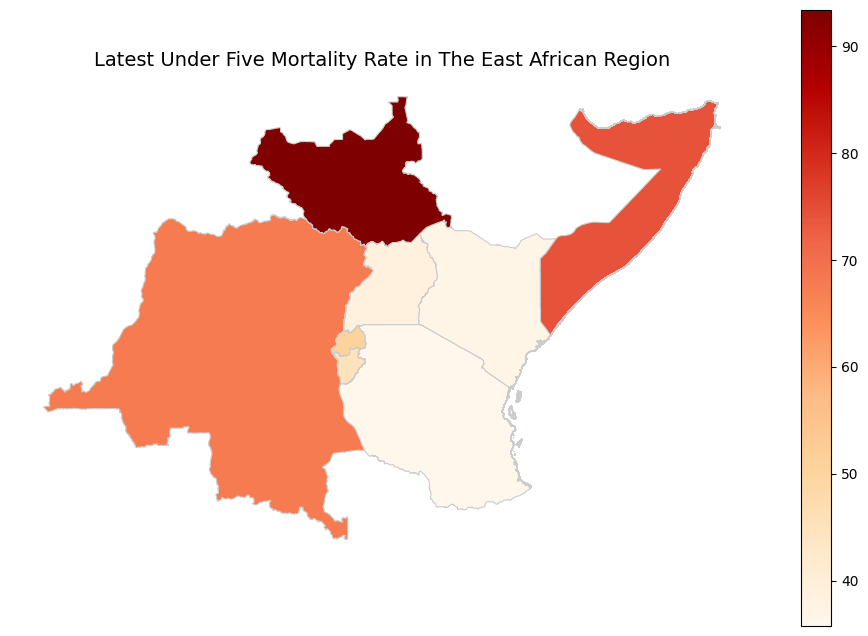

In [71]:
#List of shapefile paths to the country's shapefiles
paths_shapefile1 = [
    "gadm41_BDI_0.shp",
    "gadm41_COD_0.shp",
    "gadm41_KEN_0.shp",
    "gadm41_RWA_0.shp",
    "gadm41_SOM_0.shp",
    "gadm41_SSD_0.shp",
    "gadm41_TZA_0.shp",
    "gadm41_UGA_0.shp",
]
#Read and concatetate all the country shapefiles
geo_list1 = [gpd.read_file(path) for path in paths_shapefile1]
geo1 = pd.concat(geo_list1, ignore_index=True)

#Filter to latest year per country
latest_data1 = under_five_mort_df.sort_values("Year", ascending=False).drop_duplicates("Country")

#Merge shapefiles with new_neonatal_df
merged_data1 = geo1.merge(latest_data1, left_on="COUNTRY", right_on="Country")

#plot the choropleth
fig, ax = plt.subplots(figsize=(12, 8))
merged_data1.plot(
    column="Under_Five_Mortality_Rate",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=ax
)
ax.set_title("Latest Under Five Mortality Rate in The East African Region", fontsize=14)
ax.axis("off")
plt.show()

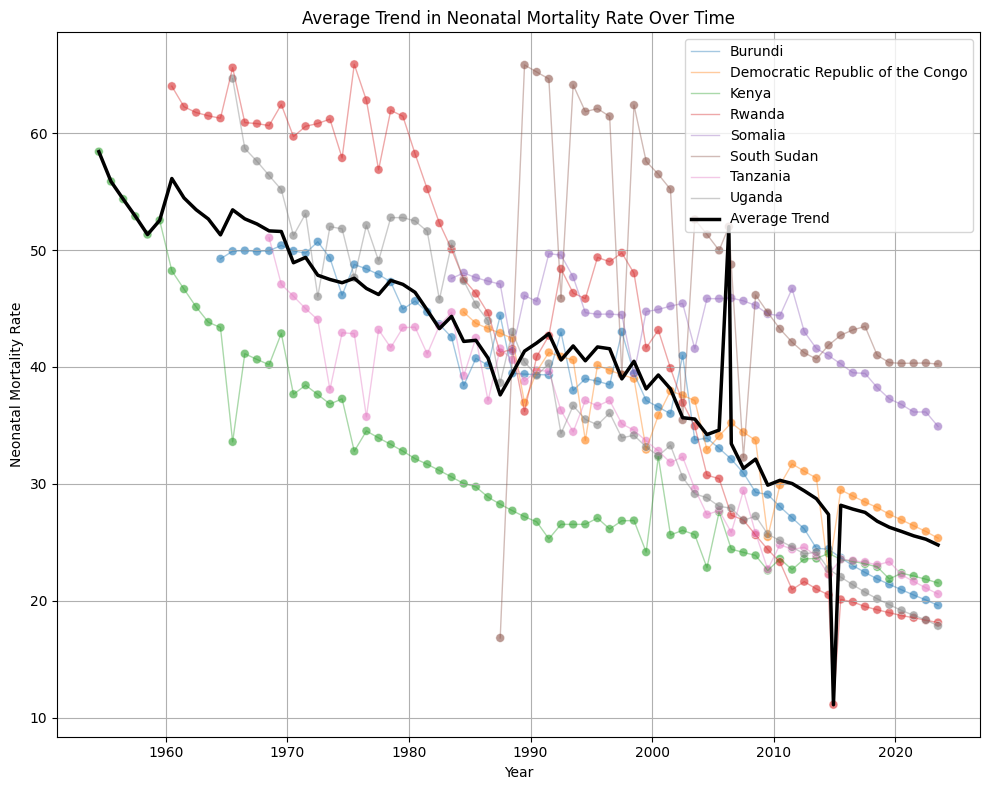

In [72]:
#Visualize the average trends in the mortality rates over time. Start with neonatal mortality rate
#Group by country and Yearly
country_avg_neonatal_df = neonatal_df.groupby(["Country", "Year"])["Neonatal_Mortality_Rate"].mean().reset_index()

#Calculate overall average per year
avg_neonatal_df = country_avg_neonatal_df.groupby("Year")["Neonatal_Mortality_Rate"].mean().reset_index()

#Plot the average per country
plt.figure(figsize=(10,8))
#Plot country trends with points and light lines
sns.lineplot(data=country_avg_neonatal_df, x="Year", y="Neonatal_Mortality_Rate", hue="Country", palette="tab10", alpha=0.4, linewidth=1)

#Add points belonging to each country
sns.scatterplot(data=country_avg_neonatal_df, x="Year", y="Neonatal_Mortality_Rate", hue="Country", palette="tab10", legend=False, alpha=0.6, s=40)

#Plot average trend line
sns.lineplot(data=avg_neonatal_df, x="Year", y="Neonatal_Mortality_Rate", color="black", label="Average Trend", linewidth=2.5)

plt.title("Average Trend in Neonatal Mortality Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Neonatal Mortality Rate")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

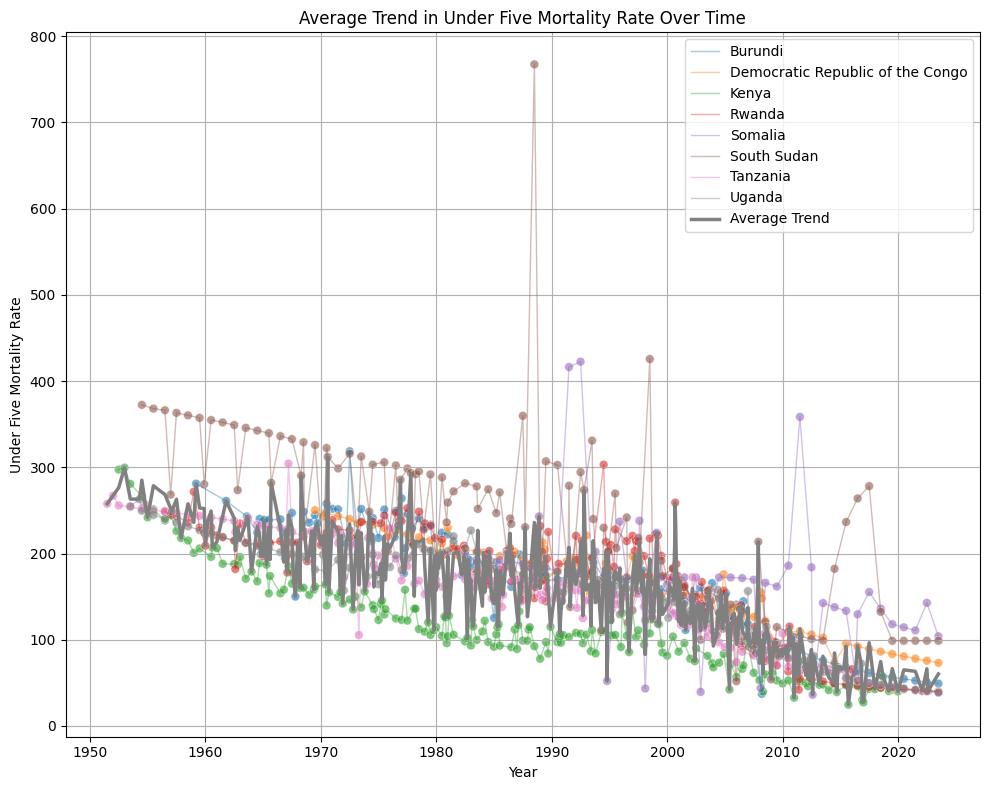

In [73]:
#Visualize the average trends in the mortality rates over time. Move to under five mortality rate
#Group by Country and Yearly
country_year_under_five_df = under_five_mort_df.groupby(["Country", "Year"])["Under_Five_Mortality_Rate"].mean().reset_index()

#Calculate overall average per year
avg_under_five_df = country_year_under_five_df.groupby("Year")["Under_Five_Mortality_Rate"].mean().reset_index()

#Plot the average per country
plt.figure(figsize=(10,8))

#Plot country trends with points and light lines
sns.lineplot(data=country_year_under_five_df, x="Year", y="Under_Five_Mortality_Rate", hue="Country", palette="tab10", alpha=0.4, linewidth=1)

#Add points belonging to each country
sns.scatterplot(data=country_year_under_five_df, x="Year", y="Under_Five_Mortality_Rate", hue="Country", palette="tab10", legend=False, alpha=0.6, s=40)

#Plot average trend line
sns.lineplot(data=avg_under_five_df, x="Year", y="Under_Five_Mortality_Rate", color="gray", label="Average Trend", linewidth=2.5)

plt.title("Average Trend in Under Five Mortality Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Under Five Mortality Rate")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
"""
Neonatal Mortality
Average Neonatal Mortality has declined over the years from 1950 to 2020 across all East African Countries evidenced in the neonatal mortality line plot.
South Sudan and Somalia exhibit the highest rates in neonatal mortality rates followed by DRC which shows some improvement, evidenced by dark red regions. In the neonatal 
mortality line plot, they both show fluctuating rates but still maintain higher averages overtime. Other countries like Kenya, Uganda, and Tanzania show declining rates.

Under Five Mortality
South Sudan and Somalia still exhibit the highest rates in under five mortality rates evidenced by dark red color in the under five neonatal mortality choropleth.
In the under five mortality rate line plot, South Sudan and Somalia have very high mortality rates in children under 5 years and show slow improvement.
Countries like Kenya, Rwanda, Uganda, DRC and Tanzania have a steady decline indicating improvement.

"""